In [1]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque

In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [4]:
junction_lane_merge = np.load('ruixuan/target_scene_index/lane_merge/scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan/target_scene_index/8KfB/scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [5]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 200  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and agent_loc.shape[0] > 100:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 100  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and  agent_loc.shape[0] > 100:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()


In [6]:
def get_trajectory(intersection_id, scene, lane_list, junction_boundary):
    
    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])
    veh_traj, ped_traj,cyclist_traj = Test.get_agent_traj(scene, 'Pedestrian', intersection_id, lane_list[intersection_id])
    return veh_traj, ped_traj,cyclist_traj

In [7]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

grid_boundary={}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [8]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [9]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_scene_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary['8KfB']['X'][0],grid_boundary['8KfB']['X'][1])
    plt.ylim(grid_boundary['8KfB']['Y'][0],grid_boundary['8KfB']['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()
    

In [10]:
def extract_trajectory_in_scene(scene, Test, zarr_dataset, intersection_id, grid_boundary):
    """
    get downsampled trajectory in a scene
    return: ego, veh, ped, cyc trajectories
    """
    frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
    length = frame_interval[1] - frame_interval[0]
#     print(length)
    
    if length<245:
        return [], [], []

    AV_data = zarr_dataset.frames[frame_interval[0]:frame_interval[1]]
    # store the AV state 
    ego = AV_data['ego_translation'][:,:2]

    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])

    # filter the agents
    car_id_list = []
    for car_id in Test.agent_list[0]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==car_id)[0]]
        if agent_loc.shape[0] > 100 and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
            car_id_list.append(car_id)
#     print("caridlist",car_id_list)
    
    pedestrian_id_list = []
    for pedestrian_id in Test.agent_list[-1]:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==pedestrian_id)[0]]
        if agent_loc.shape[0] > 100:  # more than 20 sec
            pedestrian_id_list.append(pedestrian_id)
#     print("pedidlist",pedestrian_id_list)
    cyc_id_list = []
    clist=[]
    for c in Test.agent_list[-3]:
        clist.append(c)
    for c in Test.agent_list[-5]:
        clist.append(c)
    for cyc_id in clist:
        agent_loc = Test.agent_centroid[np.where(Test.agent_id==cyc_id)[0]]
        if agent_loc.shape[0] > 100:  # more than 10 sec
            cyc_id_list.append(cyc_id)
#     print("cycidlist",cyc_id_list)
      

    sampling_id=range(0, 240,5)
    
    all_veh_traj=[]
    all_ped_traj=[]
    all_cyc_traj=[]
    
    
    for car_idx, car_id in enumerate(car_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if car_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==car_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20: # if a long trajectory is longer than 10s, we treat the rest as trajectory from other agent
                all_veh_traj.append(temp_traj)
                temp_traj=[]
              
         
    for ped_idx, ped_id in enumerate(pedestrian_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if ped_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==ped_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20:
                all_ped_traj.append(temp_traj)
                temp_traj=[]

    for cyc_idx, cyc_id in enumerate(cyc_id_list):
        temp_traj=[]
        for enum_idx, frame in enumerate(sampling_id):
            frame = frame_interval[0] + frame
#             print('frame', frame, "frame interval", Test.frames[frame]['agent_index_interval'])
            agents_info = zarr_dataset.agents[Test.frames[frame]['agent_index_interval'][0]:Test.frames[frame]['agent_index_interval'][1]]
            if cyc_id in agents_info['track_id']:    
                loc = agents_info[np.where(agents_info['track_id']==cyc_id)[0]]['centroid'][0]
                temp_traj.append(loc)
            if len(temp_traj)==20:
                all_cyc_traj.append(temp_traj)
                temp_traj=[]
    return np.array(all_veh_traj), np.array(all_ped_traj), np.array(all_cyc_traj)

In [11]:
# run an example
all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(3609, Test, zarr_dataset, '8KfB', grid_boundary=grid_boundary) # 2148, 5532
print(all_veh_traj.shape)

(5, 20, 2)


In [15]:
def get_allscenes_intersection(junction_scenes=junction_8KfB):
    final_veh, final_ped, final_cyc=None, None, None
    all_scene_dict={}
    for _, scene in enumerate(junction_scenes):
        scene_dict={'veh':[], 'ped':[], 'cyc':[]}
        print("i-th, scene", _, scene)
        all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(scene, Test, zarr_dataset, '8KfB', grid_boundary=grid_boundary) # 3134

        if len(all_veh_traj)>0:
            scene_dict['veh']=all_veh_traj
            if final_veh is None:
                final_veh = all_veh_traj
            else:
                final_veh = np.vstack((final_veh, all_veh_traj))

        if len(all_ped_traj)>0:
            scene_dict['ped']=all_ped_traj
            if final_ped is None:
                final_ped = all_ped_traj
            else:
                final_ped = np.vstack((final_ped, all_ped_traj))

        if len(all_cyc_traj)>0:
            scene_dict['cyc']=all_cyc_traj
            if final_cyc is None:
                final_cyc = all_cyc_traj
            else:
                final_cyc = np.vstack((final_cyc, all_cyc_traj))
        all_scene_dict[_]=scene_dict
    #     if _>3:
    #         break
#     np.save("saved_tensor/8kfb_alltraj_veh", final_veh)
#     np.save("saved_tensor/8kfb_alltraj_ped", final_ped)
#     np.save("saved_tensor/8kfb_alltraj_cyc", final_cyc)
    print('saved')
    
    return final_veh, final_ped, final_cyc, all_scene_dict

In [16]:
final_veh, final_ped, final_cyc, all_scene_dict = get_allscenes_intersection()
print(final_veh.shape, final_ped.shape, final_cyc.shape)

i-th, scene 0 82
i-th, scene 1 347
i-th, scene 2 380
i-th, scene 3 924
i-th, scene 4 978
i-th, scene 5 1041
i-th, scene 6 1274
i-th, scene 7 1571
i-th, scene 8 1656
i-th, scene 9 1861
i-th, scene 10 2024
i-th, scene 11 2046
i-th, scene 12 2097
i-th, scene 13 2148
i-th, scene 14 2208
i-th, scene 15 2209
i-th, scene 16 2387
i-th, scene 17 2582
i-th, scene 18 2725
i-th, scene 19 2838
i-th, scene 20 3080
i-th, scene 21 3134
i-th, scene 22 3193
i-th, scene 23 3435
i-th, scene 24 3470
i-th, scene 25 3518
i-th, scene 26 3608
i-th, scene 27 3609
i-th, scene 28 3657
i-th, scene 29 3658
i-th, scene 30 3716
i-th, scene 31 3774
i-th, scene 32 3775
i-th, scene 33 3873
i-th, scene 34 4990
i-th, scene 35 5021
i-th, scene 36 5022
i-th, scene 37 5081
i-th, scene 38 5082
i-th, scene 39 5366
i-th, scene 40 5367
i-th, scene 41 5423
i-th, scene 42 5532
i-th, scene 43 5582
i-th, scene 44 5781
i-th, scene 45 5844
i-th, scene 46 5900
i-th, scene 47 5958
i-th, scene 48 6014
i-th, scene 49 6095
i-th, scene 50 6

In [198]:
from sklearn.mixture import BayesianGaussianMixture
from tabulate import tabulate

def crop(array, max_n_agent=10, is_cyc=False):
    
    if len(array)>=max_n_agent:
        return np.array(array[:max_n_agent])
    if len(array)<max_n_agent:
        complement = np.zeros(shape=(max_n_agent-len(array), 20, 2))
        if len(array)==0:return complement
#         if is_cyc:
#             replica = math.ceil(max_n_agent/len(array))
#             array=list(array)*replica
#             return np.array(array[:max_n_agent])
        array = np.vstack((array, complement))
        return array
    else:
        return array

def _get_models(all_scene_dict):
    """
    1. convert trajectories in a scene into a sample [20, 20, 2]-> [20, 40]
    2. BGM
    3. distribution genetation
    """
    training_veh, training_ped, training_cyc = [], [], []
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        if len(veh)>0:    
            veh = crop(veh)
        if len(ped)>0:
            ped = crop(ped)
        if len(cyc)>0:
            cyc = crop(cyc,is_cyc=True)
        

        training_veh.append(veh.flatten())
        training_ped.append(ped.flatten())
        training_cyc.append(cyc.flatten())
    print("...", np.array(training_veh).shape)
    training_veh = np.array(training_veh)
    training_ped = np.array(training_ped)
    training_cyc = np.array(training_cyc)
    
    print("training veh")
    bgm_veh = BayesianGaussianMixture(n_components=3, random_state=10, reg_covar=1e-5, n_init=3).fit(training_veh)
    print("training ped")
    bgm_ped = BayesianGaussianMixture(n_components=3, random_state=20, reg_covar=1e-5, n_init=3).fit(training_ped)
    print("training cyc")
    bgm_cyc = BayesianGaussianMixture(n_components=3, random_state=30, reg_covar=1e10, max_iter=200,n_init=3).fit(training_cyc)
    
    return bgm_veh, bgm_ped, bgm_cyc
    
def _get_veh_model(all_scene_dict, k):
    training= []
    for scene, scene_dict in all_scene_dict.items():
        veh = np.array(scene_dict['veh'])
#         if len(veh)>0:
        veh = crop(veh)
        training.append(veh.flatten())
    
#     print("...", np.array(training).shape)
    training = np.array(training)
    
#     print("training veh")
    bgm_veh = BayesianGaussianMixture(n_components=k,  reg_covar=1e-5).fit(training)
  
    return bgm_veh

def _get_ped_model(all_scene_dict, k):
    training= []
    for scene, scene_dict in all_scene_dict.items():
        ped = np.array(scene_dict['ped'])
#         if len(ped)>0:
        ped = crop(ped)

        training.append(ped.flatten())
    
#     print("...", np.array(training).shape)
    training = np.array(training)
    
#     print("training ped")
    bgm_ped = BayesianGaussianMixture(n_components=k, reg_covar=1e-5 ).fit(training)
  
    return bgm_ped

def _get_cyc_model(all_scene_dict, k):
    training= []
    for scene, scene_dict in all_scene_dict.items():
        cyc = np.array(scene_dict['cyc'])
#         if len(cyc)>0:
        cyc = crop(cyc, is_cyc=True)

        training.append(cyc.flatten())
        
#     print("...", np.array(training).shape)
    training = np.array(training)
    
#     print("training cyc")
    bgm_cyc = BayesianGaussianMixture(n_components=k, \
                                      random_state=30, reg_covar=1e10, max_iter=200).fit(training)
  
    return bgm_cyc

def _get_scene_encodings(all_scene_dict, veh_model, ped_model, cyc_model):
    
    
    scene_encoding=[]
    veh_pool, ped_pool, cyc_pool={}, {}, {}
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        
        veh_p = crop(veh)
        ped_p = crop(ped)
        cyc_p = crop(cyc,is_cyc=True)
        x = veh_model.predict([veh_p.flatten()])
        y = ped_model.predict([ped_p.flatten()])
        z = cyc_model.predict([cyc_p.flatten()])
        scene_encoding.append([x[0],y[0],z[0]])
#         print(x[0], y[0], z[0], "len:",len(cyc))
        if x[0] in veh_pool and len(veh)>0:
            veh_pool[x[0]] = np.vstack((veh_pool[x[0]], veh))
        elif len(veh)>0:
            veh_pool[x[0]]= veh
            
        
        if y[0] in ped_pool and len(ped)>0:
            ped_pool[y[0]] = np.vstack((ped_pool[y[0]], ped))
        elif len(ped)>0:
            ped_pool[y[0]]= ped
            
        if z[0] in cyc_pool and len(cyc)>0:
#             print(cyc_pool[z[0]], "cyc", cyc)
            cyc_pool[z[0]] = np.vstack((cyc_pool[z[0]], cyc))
        elif len(cyc)>0:
            cyc_pool[z[0]]= cyc
        
    return np.array(scene_encoding), veh_pool, ped_pool, cyc_pool

def _get_distribution(encodings):
    """
    compute #p(Y/X), P(Z/X), P(X/Y,Z)
    """
     
    Pxy, Pxz=[],[]
#     headers = ["X=0", "X=1", "X=2"]
    veh_encoding = np.unique(encodings[:,0])
    ped_encoding = np.unique(encodings[:,1])
    cyc_encoding = np.unique(encodings[:,2])
#     print(veh_encoding, ped_encoding, cyc_encoding)
    n=len(encodings)
#     for x  in range(3):
    for x in veh_encoding:
        idx = np.where(encodings[:,0]==x)
        arr = encodings[idx]
#         print('-',len(arr))
        pxy=[]
        for y in range(3):
#         for y in ped_encoding:
            p_arr_idx = np.where(arr[:,1]==y)
            p_arr = arr[p_arr_idx]
#             print('--', len(p_arr))
            p = len(p_arr)/n
            pxy.append(p)
        Pxy.append(pxy)

        pxz=[]
        for z in range(3):
#         for z in cyc_encoding:
            c_arr_idx = np.where(arr[:,2]==z)
            c_arr = arr[c_arr_idx]
            p = len(c_arr)/n
            pxz.append(p)
        Pxz.append(pxz)
#     print(np.array(Pxy), np.sum(Pxy))
    
    Pyzx=[]
    
#     for pi in range(3):
    for pi in ped_encoding:
        pp=[]
        arr_idx= np.where(encodings[:,1]==pi)
        pi_arr=encodings[arr_idx]
        for zi in range(3):
#         for zi in cyc_encoding:
            pz=[]
            if len(pi_arr)==0:
                pz.append(0)
            else:    
                zarr_idx = np.where(pi_arr[:,2]==zi)
                if len(arr_idx)==0:
                    pz.append(0)
                else:
                    zi_arr = pi_arr[zarr_idx]
#                     for xi in range(3):
                    for xi in veh_encoding:
                        xarr_idx= np.where(zi_arr[:,0]==xi)
                        xi_arr=zi_arr[xarr_idx]
                        pz.append(len(xi_arr)/n)
            pp.append(pz)
        Pyzx.append(pp)
#     print(Pyzx, np.sum(Pyzx))
    m = np.array([['X=0'], ['X=1'], ['X=2']])
    m=[]
    headers = ["Y=0", "Y=1", "Y=2"]
    headers=[]
    for _ in veh_encoding:
        tag = 'X=' + str(_)
        m.append([tag])
    m=np.array(m)
    
    for _ in ped_encoding:
        tag = 'Y=' + str(_)
        headers.append(tag)

    table_value = np.hstack((m, Pxy))
    table = tabulate(table_value, headers, tablefmt="fancy_grid")
    print(table)
    
    headers2 = ["Z=0", "Z=1", "Z=2"]
#     headers2=[]
#     for _ in cyc_encoding:
#         tag = 'Z=' + str(_)
#         headers2.append(tag)
    
    table_value2 = np.hstack((m, Pxz))
    table2 = tabulate(table_value2, headers2, tablefmt="fancy_grid")
    print(table2)

    return np.array(Pxy), np.array(Pxz), np.array(Pyzx)



    

In [199]:
import warnings
warnings.filterwarnings('ignore')
# veh_model, ped_model, cyc_model = _get_models(all_scene_dict = all_scene_dict)
veh_model = _get_veh_model(all_scene_dict = all_scene_dict, k=3)
ped_model = _get_ped_model(all_scene_dict = all_scene_dict, k=3)
cyc_model = _get_cyc_model(all_scene_dict = all_scene_dict, k=3)
encoding, veh_pool, ped_pool, cyc_pool = _get_scene_encodings(all_scene_dict = all_scene_dict, \
                                                              veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model)
# print(encoding)
Pxy, Pxz, Pyzx = _get_distribution(encodings=encoding)
print(Pyzx.shape)

╒═════╤══════════╤═══════════╤═══════════╕
│     │      Y=0 │       Y=1 │       Y=2 │
╞═════╪══════════╪═══════════╪═══════════╡
│ X=0 │ 0.169014 │ 0.0633803 │ 0.0985915 │
├─────┼──────────┼───────────┼───────────┤
│ X=1 │ 0.28169  │ 0.056338  │ 0.105634  │
├─────┼──────────┼───────────┼───────────┤
│ X=2 │ 0.112676 │ 0.0633803 │ 0.0492958 │
╘═════╧══════════╧═══════════╧═══════════╛
╒═════╤═══════╤═══════╤══════════╕
│     │   Z=0 │   Z=1 │      Z=2 │
╞═════╪═══════╪═══════╪══════════╡
│ X=0 │     0 │     0 │ 0.330986 │
├─────┼───────┼───────┼──────────┤
│ X=1 │     0 │     0 │ 0.443662 │
├─────┼───────┼───────┼──────────┤
│ X=2 │     0 │     0 │ 0.225352 │
╘═════╧═══════╧═══════╧══════════╛
(3, 3, 3)


In [200]:
print(Pyzx)

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.16901408 0.28169014 0.11267606]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.06338028 0.05633803 0.06338028]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.09859155 0.1056338  0.04929577]]]


In [148]:
ped_pool.keys()

dict_keys([2, 1, 0])

# sampling

In [149]:
# utility functions
def get_distance(a,b):
    return np.linalg.norm(a - b, axis=1)
def get_socially_acceptable_wrate(veh):
    """
    greedy algorithm
    """
    result_veh=[]
    n = len(veh)
    x = np.zeros(shape=(n,n))
    wrate=0
    for i in range(n):
        for j in range(i,n):
#             print(i,j)
            distance = get_distance(veh[i], veh[j])
            x[i][j] = np.min(distance)
#             if np.min(distance)<4:
#                 break
    # add all that is distance> 4 with the first sample
    result_veh.append(veh[0])
    for i in range(1,n):
        if x[0][i]>4:
            result_veh.append(veh[i])
        else:
            wrate+=1
    return result_veh, wrate

def get_socially_acceptable_different_types_wrate(type1, type2):
    """
    greedy algorithm, type1 is the anchor type 
    """
    result=[]
    all_pass=True
    wrate=0
    for type2_traj in type2:
        for type1_traj in type1:
            distance = get_distance(type1_traj, type2_traj)
            if min(distance)<4:
                all_pass=False
                wrate+=1
                break 
        if all_pass:
            result.append(type2_traj)
    return result, wrate

def socially_acceptance_check_wrate(veh, ped, cyc):
    n_agents = len(veh) + len(ped) + len(cyc)
    #check socially acceptable trajectories
    veh_s, wrate1 = get_socially_acceptable_wrate(veh)
    ped_s, wrate2 = get_socially_acceptable_wrate(ped)
    cyc_s, wrate3 = get_socially_acceptable_wrate(cyc)
    
    # check constrains on ped_s
    ped_s, wrate4 = get_socially_acceptable_different_types_wrate(veh_s, ped_s)
    
    #check socially acceptable trajectories considering environment
    cyc_s, wrate5 = get_socially_acceptable_different_types_wrate(ped_s, cyc_s)
    cyc_s, wrate6 = get_socially_acceptable_different_types_wrate(veh_s, cyc_s)
#     print(len(veh_s), len(ped_s), len(cyc_s))
    
    removing_rate = (wrate1 + wrate2 + wrate3 + wrate4 + wrate5 +wrate6)/n_agents
    return np.array(veh_s), np.array(ped_s), np.array(cyc_s), removing_rate

In [162]:
def Gibbs_sampling_checkn(max_scene=1000,Pxy=Pxy, Pxz=Pxz, Pyzx=Pyzx, \
                   poolv=veh_pool, poolp=ped_pool, poolc=cyc_pool,\
                   veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model, \
                   max_n_veh=20, max_n_ped=3, max_n_cyc=3):
    sampling_result={}
    
    # initialization
    veh_0, ped_0, cyc_0 = poolv[list(poolv.keys())[0]], poolp[list(poolp.keys())[0]], poolc[list(poolc.keys())[0]], 
    veh =veh_0[np.random.choice(veh_0.shape[0], max_n_veh, replace=False)]
    ped =ped_0[np.random.choice(ped_0.shape[0], max_n_ped, replace=False)]
    cyc =cyc_0[np.random.choice(cyc_0.shape[0], max_n_cyc, replace=False)]
    
    n_scene=0
    result_removing=0
    while n_scene < max_scene:
        scene_data={}
        veh_p = crop(veh)
        ped_p = crop(ped)
        cyc_p = crop(cyc,is_cyc=True)
        
        x = veh_model.predict([veh_p.flatten()])[0]
        y = ped_model.predict([ped_p.flatten()])[0]
        z = cyc_model.predict([cyc_p.flatten()])[0]

        try:
            x = list(poolv.keys()).index(x)
        except:
            np.random.choice(list(poolv.keys()))
            
        try:
            y = list(poolp.keys()).index(y)
        except:
            y = np.random.choice(list(poolp.keys()))
        try:
            z = list(poolc.keys()).index(z)
        except:
            z=np.random.choice(list(poolc.keys()))
        pxy = Pxy[x]/np.linalg.norm(Pxz[x], ord=1)
#         print(list(poolp.keys()), x, pxy)
        try:
            ped_category = np.random.choice(list(poolp.keys()), p=pxy)
        except:
            ped_category = np.random.choice(list(poolp.keys()))
#         print("ped category",ped_category)
        #sample trajectories
        ped_under_category = poolp[ped_category]
        ped =ped_under_category[np.random.choice(ped_under_category.shape[0], max_n_ped, replace=False)]
#         ped = poolp[ped_category][ped_idx]
#         print(ped.shape)
        
        pxz = Pxz[x]/np.linalg.norm(Pxz[x], ord=1)
        key_list= list(poolc.keys())
#         print(key_list, pxz)
#         if len(key_list)!= len(pxz):
#             key_list=range(len(pxz))
        try:
            cyc_category = np.random.choice(key_list, p=pxz)
        except:
            cyc_category = np.random.choice(key_list)
        cyc_under_category = poolc[cyc_category]
#         print('cyc category', cyc_category)
        cyc =cyc_under_category[np.random.choice(cyc_under_category.shape[0], max_n_cyc, replace=False)]
        
#         print(Pyzx.shape, Pyzx[y][z].shape)
        pyzx = Pyzx[y][z]/np.linalg.norm(Pyzx[y][z], ord=1)
        try:
            v_category = np.random.choice(list(poolv.keys()), p=pyzx)
        except:
            v_category = np.random.choice(list(poolv.keys()))
#         print('veh category', v_category)
        veh_under_category = poolv[v_category]
        veh =veh_under_category[np.random.choice(veh_under_category.shape[0], max_n_veh, replace=False)]
        
        
        
        veh, ped, cyc, removing_rate = socially_acceptance_check_wrate(veh, ped, cyc)
        result_removing += removing_rate
#         if len(veh)==0 or len(ped)==0 or len(cyc)==0:
#             continue
        scene_data['ped']=ped
        scene_data['cyc']=cyc
        scene_data['veh']=veh
        sampling_result[n_scene] = scene_data
        n_scene+=1
        
    return sampling_result, result_removing/max_scene

In [151]:
_, rate = Gibbs_sampling_checkn()
print(rate)

0.26544999999999996


# wrap together

In [163]:
result=[]
for vk in range(2, 10):
    veh_model = _get_veh_model(all_scene_dict = all_scene_dict, k=vk)
    for pk in range(2,6):
        ped_model = _get_ped_model(all_scene_dict = all_scene_dict, k=pk)
        for ck in range(1,4):
            cyc_model = _get_cyc_model(all_scene_dict = all_scene_dict, k=ck)
            print("components for veh/ped/cyc:", vk, pk, ck)
            encoding, veh_pool, ped_pool, cyc_pool = _get_scene_encodings(all_scene_dict = all_scene_dict, \
                                                              veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model)
            # print(encoding)
            Pxy, Pxz, Pyzx = _get_distribution(encodings=encoding)
            _, rate = Gibbs_sampling_checkn(max_scene=1000,Pxy=Pxy, Pxz=Pxz, Pyzx=Pyzx, \
                   poolv=veh_pool, poolp=ped_pool, poolc=cyc_pool,\
                   veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model, \
                   max_n_veh=10, max_n_ped=5, max_n_cyc=5)
            print(rate)
            result.append([vk,pk,ck, rate])

components for veh/ped/cyc: 2 2 1
0.26179999999999964


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 2 2
0.26075000000000015


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 2 3
0.2666500000000003
components for veh/ped/cyc: 2 3 1
0.2593500000000003


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 3 2
0.26074999999999987


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 3 3
0.2617
components for veh/ped/cyc: 2 4 1
0.2633000000000001


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 4 2
0.26309999999999995


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 4 3
0.2667499999999997
components for veh/ped/cyc: 2 5 1
0.26910000000000006


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 5 2
0.2655499999999999


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 2 5 3
0.26585000000000003
components for veh/ped/cyc: 3 2 1
0.22719999999999996


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 2 2
0.22929999999999978


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 2 3
0.22839999999999996
components for veh/ped/cyc: 3 3 1
0.22174999999999978


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 3 2
0.22419999999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 3 3
0.22785
components for veh/ped/cyc: 3 4 1
0.22624999999999967


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 4 2
0.22730000000000003


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 4 3
0.23145
components for veh/ped/cyc: 3 5 1
0.22484999999999977


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 5 2
0.22684999999999983


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 3 5 3
0.22515000000000024
components for veh/ped/cyc: 4 2 1
0.26664999999999983


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 2 2
0.26479999999999965


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 2 3
0.26494999999999985
components for veh/ped/cyc: 4 3 1
0.2535


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 3 2
0.25969999999999976


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 3 3
0.25934999999999997
components for veh/ped/cyc: 4 4 1
0.2686000000000002


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 4 2
0.26660000000000034


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 4 3
0.2649000000000002
components for veh/ped/cyc: 4 5 1
0.2572999999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 5 2
0.26070000000000004


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 4 5 3
0.26179999999999964
components for veh/ped/cyc: 5 2 1
0.2542500000000001


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 2 2
0.25434999999999997


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 2 3
0.25185
components for veh/ped/cyc: 5 3 1
0.25819999999999976


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 3 2
0.25824999999999987


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 3 3
0.24994999999999992
components for veh/ped/cyc: 5 4 1
0.25685


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 4 2
0.26284999999999953


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 4 3
0.25674999999999953
components for veh/ped/cyc: 5 5 1
0.2618499999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 5 2
0.2531000000000002


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 5 5 3
0.2557999999999999
components for veh/ped/cyc: 6 2 1
0.25910000000000005


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 2 2
0.25835000000000014


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 2 3
0.2617499999999999
components for veh/ped/cyc: 6 3 1
0.2540499999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 3 2
0.25709999999999983


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 3 3
0.26009999999999994
components for veh/ped/cyc: 6 4 1
0.26670000000000016


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 4 2
0.25775000000000037


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 4 3
0.26134999999999986
components for veh/ped/cyc: 6 5 1
0.26040000000000024


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 5 2
0.2595500000000001


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 6 5 3
0.25749999999999984
components for veh/ped/cyc: 7 2 1
0.2621999999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 2 2
0.2647


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 2 3
0.2657
components for veh/ped/cyc: 7 3 1
0.2576


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 3 2
0.2528999999999997


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 3 3
0.2529
components for veh/ped/cyc: 7 4 1
0.2616


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 4 2
0.2617999999999998


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 4 3
0.26465000000000044
components for veh/ped/cyc: 7 5 1
0.25634999999999986


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 5 2
0.25339999999999996


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 7 5 3
0.25450000000000006
components for veh/ped/cyc: 8 2 1
0.24615


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 2 2
0.25074999999999986


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 2 3
0.25169999999999976
components for veh/ped/cyc: 8 3 1
0.2565499999999996


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 3 2
0.25209999999999977


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 3 3
0.24905000000000002
components for veh/ped/cyc: 8 4 1
0.24564999999999965


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 4 2
0.24950000000000006


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 4 3
0.2465000000000003
components for veh/ped/cyc: 8 5 1
0.24334999999999996


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 5 2
0.24894999999999967


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 8 5 3
0.25189999999999985
components for veh/ped/cyc: 9 2 1
0.2503499999999996


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 2 2
0.24954999999999988


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 2 3
0.25164999999999976
components for veh/ped/cyc: 9 3 1
0.24664999999999992


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 3 2
0.25164999999999976


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 3 3
0.24689999999999993
components for veh/ped/cyc: 9 4 1
0.24794999999999995


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 4 2
0.24804999999999974


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 4 3
0.25390000000000007
components for veh/ped/cyc: 9 5 1
0.2513499999999999


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 5 2
0.2445999999999999


/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


components for veh/ped/cyc: 9 5 3
0.24759999999999993


In [172]:
result.sort(key=lambda x: x[3])
print(result[0:5])

[[3, 3, 1, 0.22174999999999978], [3, 3, 2, 0.22419999999999998], [3, 5, 1, 0.22484999999999977], [3, 5, 3, 0.22515000000000024], [3, 4, 1, 0.22624999999999967]]


In [267]:
# original_result = np.load('SensAnalysis.npy')
result = np.array(result)
vvk=[]
for vk in range(2,10):
    arr_id = np.where(result[:,0]==vk)
    arr = result[arr_id]
    avg = np.mean(arr[:,3])
    vvk.append(avg)
print(vvk)

[0.2637208333333333, 0.22671249999999996, 0.2624041666666666, 0.2561708333333332, 0.25947499999999996, 0.25902499999999995, 0.24934583333333324, 0.2491833333333332]


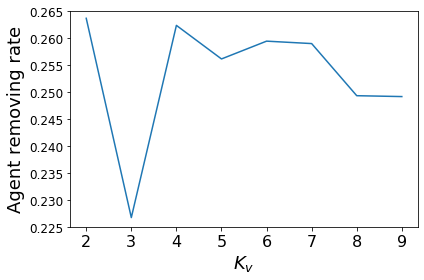

In [268]:
xdim = np.arange(2,10).astype(int).astype(str)
plt.plot(xdim, vvk)
plt.xlabel('$K_v$', fontsize=18)
plt.ylabel('Agent removing rate', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0.225,0.265)
plt.tight_layout()
plt.savefig('sens_bgm_veh', dpi=100)
plt.show()

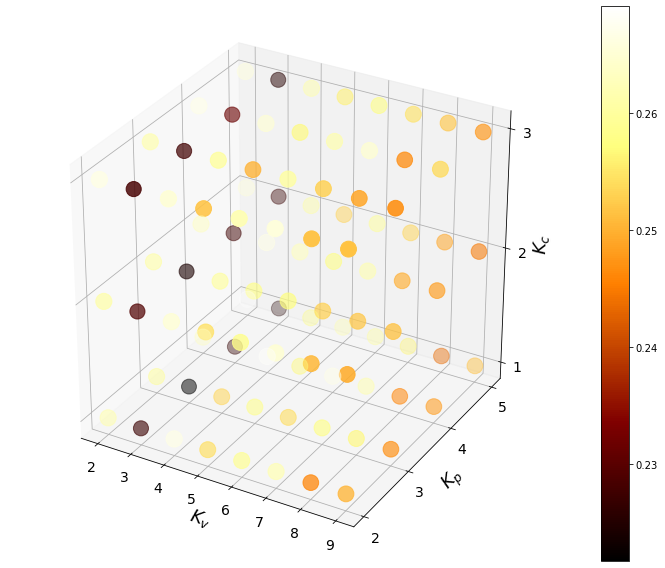

In [262]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator



fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')


img = ax.scatter(result[:,0], result[:,1], result[:,2], c=result[:,3], s=result[:,3]*1000, cmap=plt.get_cmap('afmhot'))
fig.colorbar(img)
ax.set_xlabel('$K_v$', fontsize=18)
ax.set_ylabel('$K_p$', fontsize=18)
ax.set_zlabel('$K_c$', fontsize=18)
# plt.title('Sensitivity anslysis on # components')
plt.tight_layout()
# ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize= 14)
ax.tick_params(axis='y', labelsize= 14)
ax.tick_params(axis='z', labelsize= 14)

plt.savefig("sensAnalysis")
plt.show()

In [201]:
np.save('SensAnalysis', result)